**Food Image Classification**


 Project Statement:


 Train a CNN to classify images of food into categories like pizza, burger, dosa, idli, etc.


 Goal:
 Build an image-based food recommendation or ordering system.


 Dataset:
 Use Food-101 Dataset or Kaggle food datasets.

**1. Data Preparation**

(Mounting drive, extracting ZIP, inspecting categories, and splitting into train/val/test)

In [ ]:
# Importing necessary libraries for model building, preprocessing, evaluation and visualization

import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
import numpy as np

In [ ]:
# Mounting Google Drive to access dataset stored in Drive

from google.colab import drive
drive.mount('/content/drive')
print("drive mounted")

Mounted at /content/drive
drive mounted


In [ ]:
'''# Extracting the zip file containing food images into a specific folder

import zipfile

zip_path = "/content/drive/MyDrive/images.zip"
extract_path = "/content/drive/MyDrive/food_images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete.")
'''

In [ ]:
# Counting and displaying the number of images per food category in the dataset

import os

data_path = "/content/drive/MyDrive/Food_Images"
categories = os.listdir(data_path)

print(f"Found {len(categories)} categories:\n")
for category in categories:
    category_path = os.path.join(data_path, category)
    if os.path.isdir(category_path):
        num_images = len(os.listdir(category_path))
        print(f"{category}: {num_images} images")


Found 7 categories:

baklava: 1000 images
waffles: 1000 images
ramen: 1000 images
samosa: 1000 images
tiramisu: 1000 images
ice_cream: 1000 images
pizza: 1000 images


In [ ]:
# Listing all food categories present in the dataset folder

import os

original_dir = '/content/drive/MyDrive/Food_Images'
categories = os.listdir(original_dir)
print("Food Categories:", categories)


Food Categories: ['baklava', 'waffles', 'ramen', 'samosa', 'tiramisu', 'ice_cream', 'pizza']


In [ ]:
# Function to split dataset into training, validation, and test subsets (70/15/15)
# This helps train and evaluate the model on separate, balanced data

import os, shutil, pathlib
import random

random.seed(42)  # for reproducibility

original_dir = pathlib.Path("/content/drive/MyDrive/Food_Images")
new_base_dir = pathlib.Path("/content/drive/MyDrive/food_img_seg")
categories = [d for d in os.listdir(original_dir) if os.path.isdir(original_dir / d)]

def make_subset(subset_name, start_ratio, end_ratio):
    for category in categories:
        src_dir = original_dir / category
        dest_dir = new_base_dir / subset_name / category

        # Clear existing dest_dir to avoid duplicates
        if os.path.exists(dest_dir):
            shutil.rmtree(dest_dir)
        os.makedirs(dest_dir, exist_ok=True)

        images = [f for f in os.listdir(src_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        total = len(images)
        start_idx = int(start_ratio * total)
        end_idx = int(end_ratio * total)

        for fname in images[start_idx:end_idx]:
            shutil.copyfile(src=src_dir / fname, dst=dest_dir / fname)

        print(f"{subset_name}/{category}: {end_idx - start_idx} images copied.")

make_subset("train", 0.0, 0.7)
make_subset("validation", 0.7, 0.85)
make_subset("test", 0.85, 1.0)

# Splits the dataset into train, validation, and test folders.
# It physically copies images into separate subdirectories per category.


train/baklava: 700 images copied.
train/waffles: 700 images copied.
train/ramen: 700 images copied.
train/samosa: 700 images copied.
train/tiramisu: 700 images copied.
train/ice_cream: 700 images copied.
train/pizza: 700 images copied.
validation/baklava: 150 images copied.
validation/waffles: 150 images copied.
validation/ramen: 150 images copied.
validation/samosa: 150 images copied.
validation/tiramisu: 150 images copied.
validation/ice_cream: 150 images copied.
validation/pizza: 150 images copied.
test/baklava: 150 images copied.
test/waffles: 150 images copied.
test/ramen: 150 images copied.
test/samosa: 150 images copied.
test/tiramisu: 150 images copied.
test/ice_cream: 150 images copied.
test/pizza: 150 images copied.


**2. Data Preprocessing**

(Loading images, resizing, normalizing, and encoding labels)

In [ ]:
# Loading and preprocessing images:
# - Convert to RGB
# - Resize to 224x224
# - Assign numeric label to each category
# Preprocess images: Resize to 224x224, Convert to RGB, Label Encoding

import cv2
import numpy as np
import os

selected_categories = ['baklava', 'waffles', 'ramen', 'samosa', 'tiramisu', 'ice_cream', 'pizza']

img_size = 224

def get_data(data_dir):
    images = []
    image_labels = []
    for class_num, label in enumerate(selected_categories):
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]  # Convert BGR to RGB
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                images.append(resized_arr)
                image_labels.append(class_num)
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    return np.array(images), np.array(image_labels)


# Loads images from a given directory, resizes them, and assigns numerical labels.
# Returns image arrays and corresponding one-hot encoded class labels.

In [ ]:
data_base_dir = "/content/drive/MyDrive/food_img_seg"

train_images, train_labels = get_data(os.path.join(data_base_dir, 'train'))
val_images, val_labels = get_data(os.path.join(data_base_dir, 'validation'))

# Loading training and validation data using the get_data function


In [ ]:
# Displaying shapes of training and validation data and number of unique classes

print("Train images shape:", train_images.shape)
print("Validation images shape:", val_images.shape)
print("Unique training labels:", np.unique(train_labels))
print("Number of classes:", len(selected_categories))


Train images shape: (4900, 224, 224, 3)
Validation images shape: (1050, 224, 224, 3)
Unique training labels: [0 1 2 3 4 5 6]
Number of classes: 7


In [ ]:
#Normalizing data
# Normalizing image pixel values (scaling to range [0,1])
# Converting integer labels to one-hot encoded vectors for classification


from tensorflow.keras.utils import to_categorical

x_train = train_images.astype('float32') / 255.0
x_val = val_images.astype('float32') / 255.0

num_classes = len(selected_categories)

y_train = to_categorical(train_labels, num_classes)
y_val = to_categorical(val_labels, num_classes)


assert y_train.shape[1] == num_classes, "Mismatch in number of classes"


**3. Data Augmentation**

(Using ImageDataGenerator to apply transformations and create generators)

In [ ]:
# Defining ImageDataGenerators:
# - Training: with data augmentation (rotation, zoom, flip, shift)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)


val_datagen = ImageDataGenerator()

# Creating batch generators
train_generator = train_datagen.flow(x_train, y_train, batch_size=32, shuffle=True, seed=42)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32, shuffle=False)

#applying agumentation so that model  doesnt lead to overfitting and improves learning

In [ ]:
print(f"Training samples: {x_train.shape[0]}")
print(f"Validation samples: {x_val.shape[0]}")


Training samples: 4900
Validation samples: 1050


**4. Model Building**

(Using Mobilenet base, adding custom layers, freezing base, defining architecture)

In [ ]:
#Model definition

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# number of classes from generator
num_classes = len(selected_categories)

# Load base model (MobileNetV2), exclude top classifier
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers initially
for layer in mobilenet_base.layers:
    layer.trainable = False

# Define final model
model = Sequential([
    mobilenet_base,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])





9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**5. Model Compilation & Training**

(Compiling model, applying EarlyStopping and ModelCheckpoint, fitting the model)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

#using earlystopping to stop training upon no improvement for 5 consecutive epochs

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(
    filepath='/content/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

#using modelcheckpoint to store best weights

In [ ]:
#compile model
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Compiling model with Adam optimizer and categorical crossentropy loss for multi-class classification


In [ ]:
#train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, model_ckpt],
    verbose=2
)


# Training the model using fit() with early stopping and checkpoint callbacks


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.78952, saving model to /content/best_model.keras
154/154 - 80s - 521ms/step - accuracy: 0.4959 - loss: 1.4702 - val_accuracy: 0.7895 - val_loss: 0.6929
Epoch 2/30

Epoch 2: val_accuracy improved from 0.78952 to 0.82857, saving model to /content/best_model.keras
154/154 - 56s - 363ms/step - accuracy: 0.7280 - loss: 0.8361 - val_accuracy: 0.8286 - val_loss: 0.5280
Epoch 3/30

Epoch 3: val_accuracy improved from 0.82857 to 0.84381, saving model to /content/best_model.keras
154/154 - 56s - 361ms/step - accuracy: 0.7663 - loss: 0.6980 - val_accuracy: 0.8438 - val_loss: 0.4659
Epoch 4/30

Epoch 4: val_accuracy improved from 0.84381 to 0.85714, saving model to /content/best_model.keras
154/154 - 55s - 359ms/step - accuracy: 0.7961 - loss: 0.6217 - val_accuracy: 0.8571 - val_loss: 0.4328
Epoch 5/30

Epoch 5: val_accuracy improved from 0.85714 to 0.86762, saving model to /content/best_model.keras
154/154 - 55s - 360ms/step - accuracy: 0.

In [ ]:
# Define your destination path
destination_path = '/content/drive/MyDrive/best_model.keras'

# Copy the file to Drive
!cp /content/best_model.keras "$destination_path"


In [ ]:
from keras.models import load_model

# Load the saved model from Google Drive
model = load_model('/content/drive/MyDrive/best_model.keras')


In [ ]:
model.summary()

# Printing model summary (architecture, parameters, layers)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,257,431 (12.43 MB)

 Trainable params: 332,295 (1.27 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

 Optimizer params: 664,592 (2.54 MB)

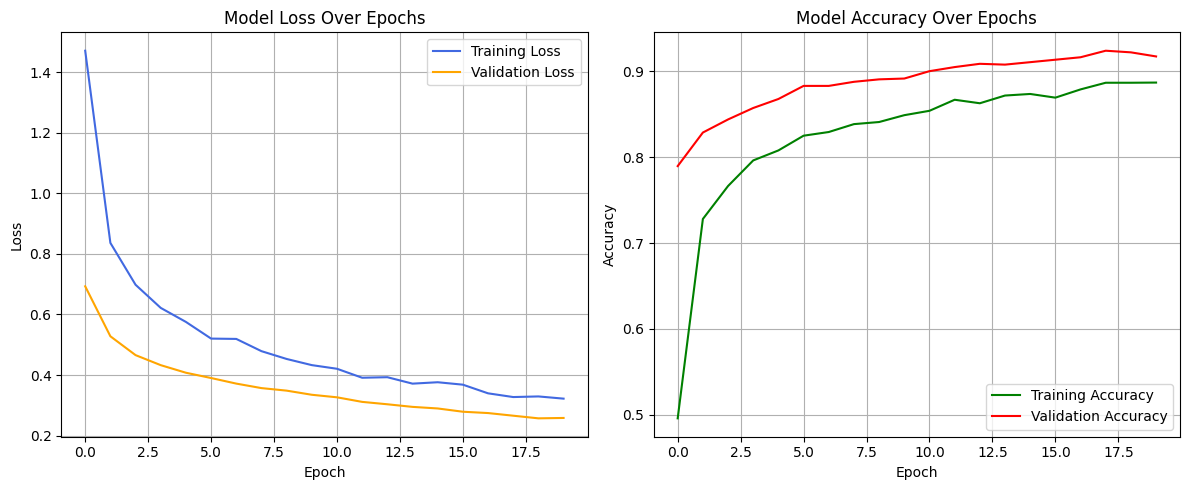

In [ ]:
# Plotting training vs validation loss and accuracy to monitor model performance visually over epochs

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='royalblue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy Over Epochs')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


**6. Model Evaluation**

(Accuracy, classification report, confusion matrix visualization)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Accuracy: 0.9238

Classification Report:
              precision    recall  f1-score   support

     baklava       0.91      0.92      0.92       150
     waffles       0.89      0.91      0.90       150
       ramen       0.97      0.98      0.98       150
      samosa       0.90      0.91      0.91       150
    tiramisu       0.94      0.90      0.92       150
   ice_cream       0.90      0.94      0.92       150
       pizza       0.96      0.91      0.93       150

    accuracy                           0.92      1050
   macro avg       0.92      0.92      0.92      1050
weighted avg       0.92      0.92      0.92      1050



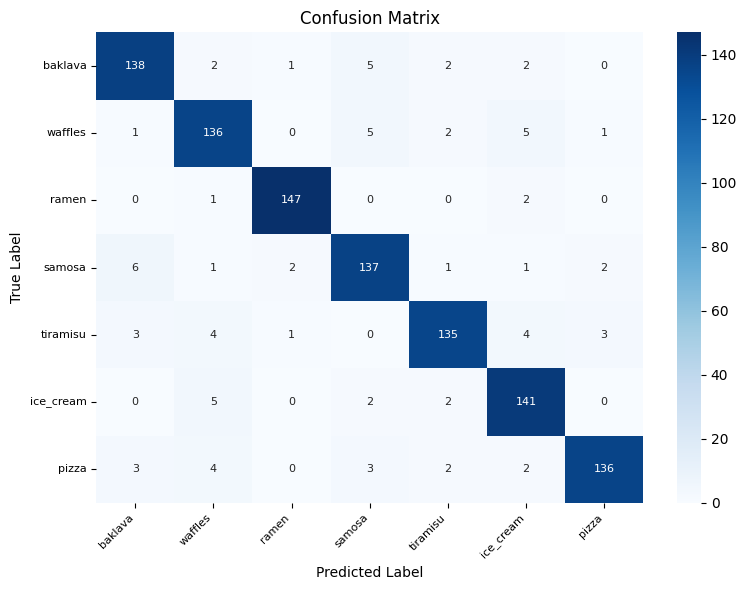

In [ ]:
#Evaluation metrics
# Predicting on validation set
# Calculating accuracy, printing classification report and confusion matrix
# Visualizing confusion matrix using seaborn heatmap


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# Predict on validation data
y_pred_probs = model.predict(x_val, verbose=1) # Predict directly on x_val
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels from original validation labels
y_true = val_labels

# Get class labels in correct order
labels = selected_categories

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(8, 6))  # Reduced from (14, 12)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 8})
plt.title("Confusion Matrix", fontsize=12)
plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

**7. Model Testing**

(Predicting new images and displaying results)

baklava.jpg: baklava (96.3%)


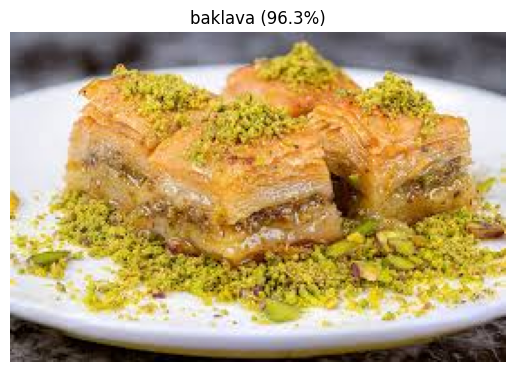

pizza.jpeg: pizza (100.0%)


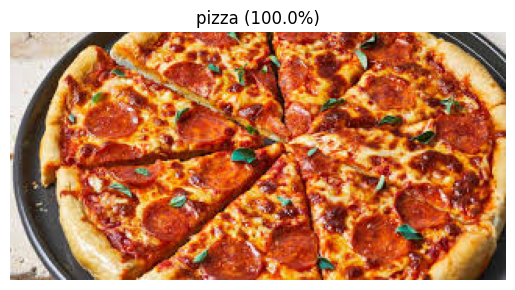

ramen.jpg: ramen (99.5%)


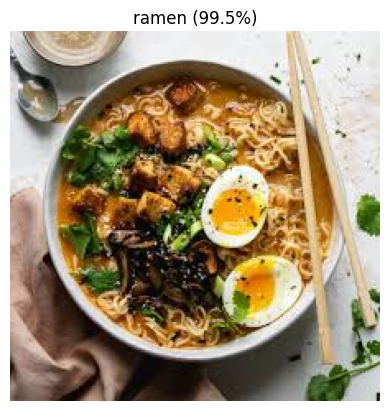

samosa.jpg: samosa (100.0%)


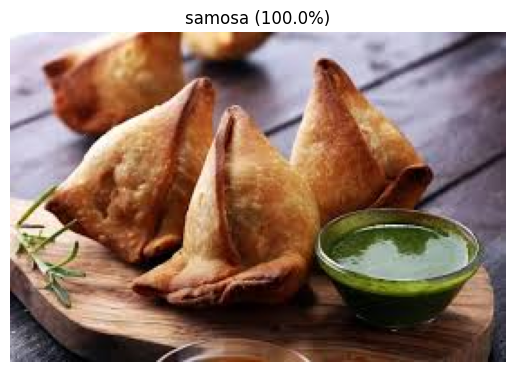

tiramisu.jpg: tiramisu (99.9%)


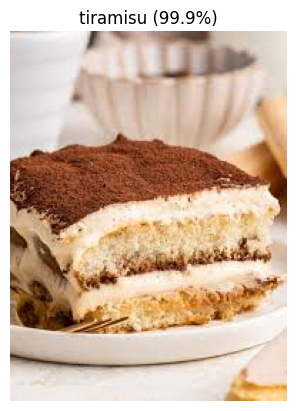

waffles.jpg: waffles (99.2%)


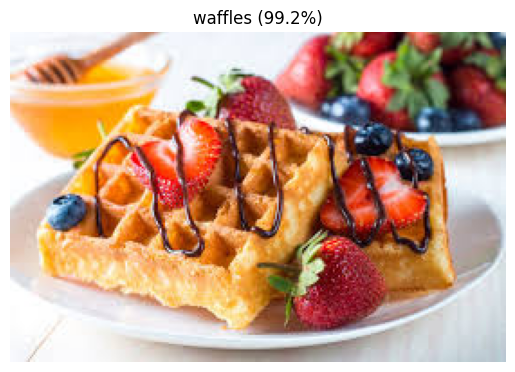

In [ ]:
# Model Testing on Custom Images

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

test_folder = "/content/drive/MyDrive/test_images"
labels = selected_categories  # class names

for fname in sorted(os.listdir(test_folder)):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(test_folder, fname)
        img_bgr = cv2.imread(img_path)

        if img_bgr is None or len(img_bgr.shape) != 3:
            print(f"Skipping: {fname}")
            continue

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (224, 224))
        img_array = img_to_array(img_resized) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array, verbose=0)
        predicted_index = np.argmax(prediction)
        predicted_class = labels[predicted_index]
        confidence = prediction[0][predicted_index] * 100

        print(f"{fname}: {predicted_class} ({confidence:.1f}%)")

        plt.imshow(img_rgb)
        plt.title(f"{predicted_class} ({confidence:.1f}%)")
        plt.axis('off')
        plt.show()


**My Review**

Objective:
In this project, I built a CNN-based model to classify food images into 7 categories like pizza, samosa , and ice cream for potential use in food recommendation or ordering systems.

1. Data Preparation
I worked with ~7,000 food images and split them into 70% training, 15% validation, and 15% test sets. I organized the data into category-wise directories using a reproducible script.

2. Data Preprocessing
I resized all images to 224×224, normalized pixel values, and applied one-hot encoding to labels. Initially used in-memory loading, then moved to ImageDataGenerator for better efficiency.

3. Data Augmentation
To reduce overfitting, I applied rotation, zoom, shift, and horizontal flip augmentations using ImageDataGenerator.

4. Model Architecture
I used MobileNetV2 as the base model with frozen layers and added custom layers (GAP, BatchNorm, Dense, Dropout, Softmax) for final classification.

5. Model Training
Compiled the model with Adam optimizer and categorical crossentropy. Used EarlyStopping and ModelCheckpoint to train for up to 30 epochs with validation monitoring.

6. Evaluation
Evaluated the model using validation accuracy, classification report, and confusion matrix. Plotted loss and accuracy curves to track performance.Obtained about ~92 percent accuracy for this model

7. Custom Image Testing
Tested the model on unseen images, displaying predictions and confidence scores with matplotlib. Added a confidence check to handle uncertain predictions.

Key Takeaways
I learned to manage image data efficiently, apply transfer learning with MobileNetV2, and build a reliable end-to-end classification pipeline with evaluation and custom testing.